In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import io
import re
from scipy.io.wavfile import read
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from pathlib import Path
from sklearn.cluster import KMeans
import copy

In [116]:
def load_waveform(filepath):
    with open(filepath) as dataFile:
        data = dataFile.read()
        # Check for missing commas and insert them
        pattern = r'(\{[^{}]*"[^"]*"[^{}]*\})(?=[^{}]*\{)'
        data = re.sub(pattern, r'\1,', data)

        obj = data[data.find('{') : data.rfind('}')+1]
        jsonObj = json.loads(obj)
        
        if jsonObj['data']:
            waveform_data = pd.DataFrame(jsonObj['data'], columns=["peak_amplitude","integral","phase_angle","cycle_number","rise_time","pulse_width"])    
            return waveform_data
    return None


In [117]:
dirpaths = ["C://Users//Dave//Desktop//MACHINELEARNING//positive"]

In [118]:
dataframes = []

for dirpath in dirpaths:
    for filename in os.listdir(dirpath):
        if filename.endswith(".js"):
            filepath = os.path.join(dirpath, filename)
            waveform = load_waveform(filepath)
           # if not waveform.empty:
            dataframes.append(waveform)

In [119]:
output_folder = "C://Users//Dave//Desktop//MACHINELEARNING//kmeanspositive_plots"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [120]:
def bucket_phase_angle(phase_angle, num_buckets=36):
    bucket_size = 360 // num_buckets
    return phase_angle // bucket_size

In [121]:
def determine_baseline(bucket_data, kmeans, predicted_clusters, threshold=5):
    centroids = kmeans.cluster_centers_
    centroid_distance = abs(centroids[1] - centroids[0])

    if centroid_distance > threshold:
        # Clusters far apart - Outcome 1
        lower_centroid_index = np.argmin(centroids)
        lower_cluster = bucket_data[predicted_clusters == lower_centroid_index]
        return max(lower_cluster['peak_amplitude'])
    else:
        # Clusters close together - Outcome 2
        higher_centroid_index = np.argmax(centroids)
        return centroids[higher_centroid_index][0]

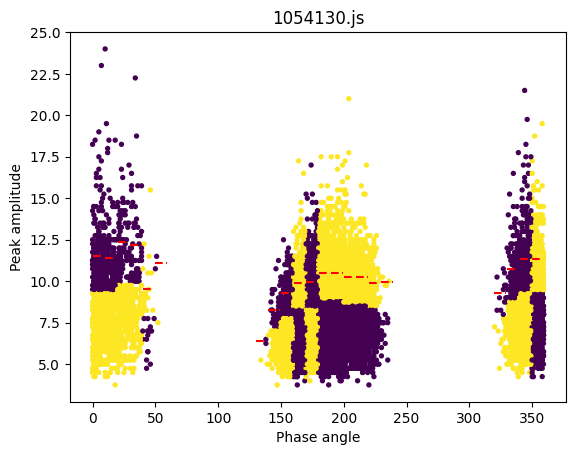

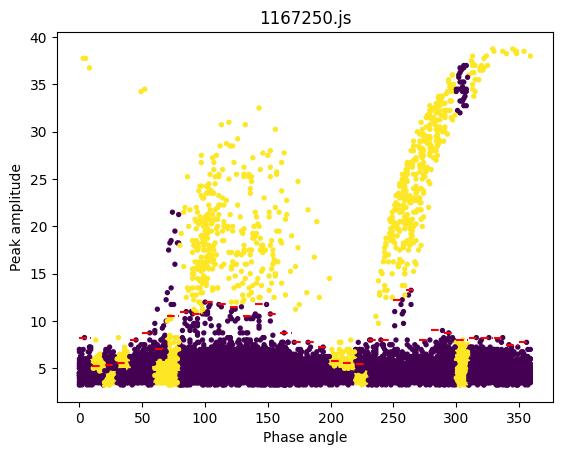

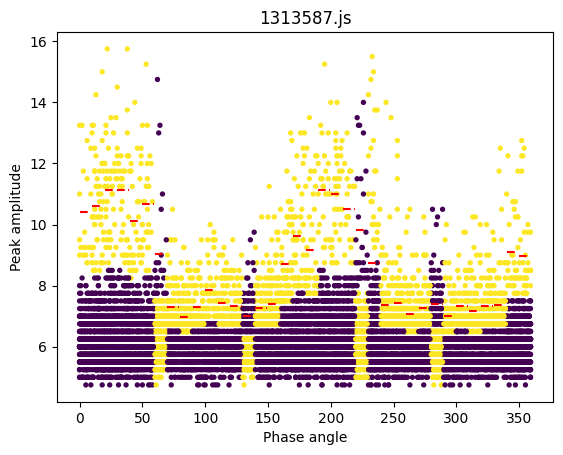

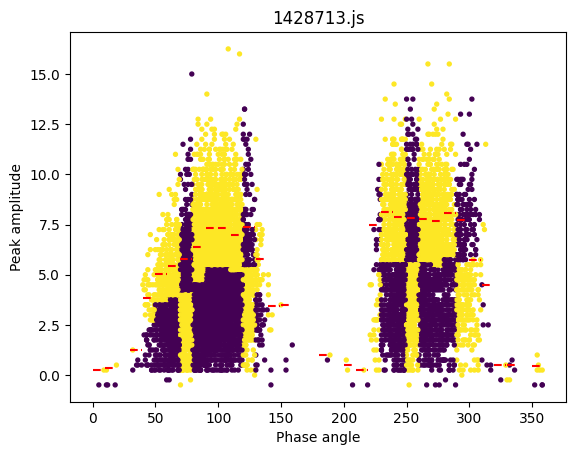

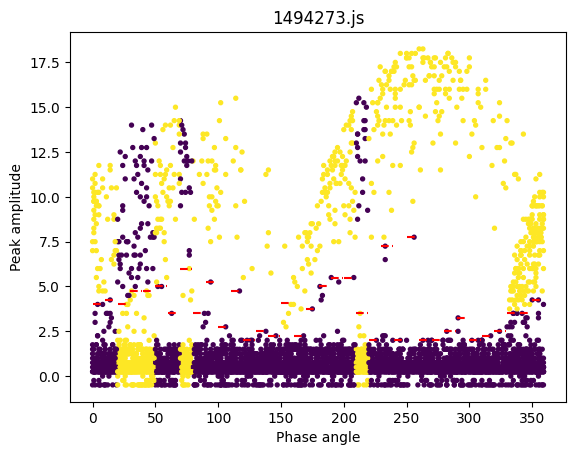

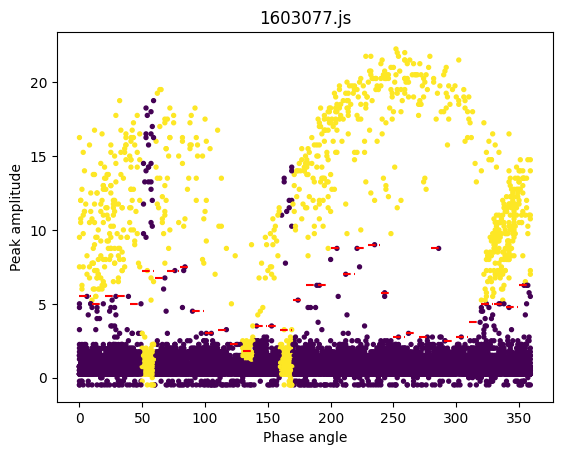

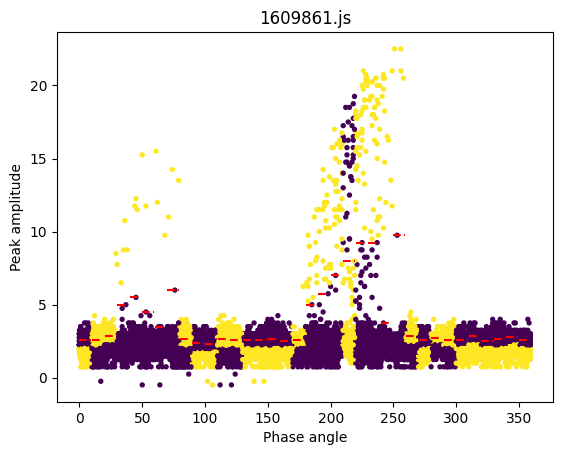

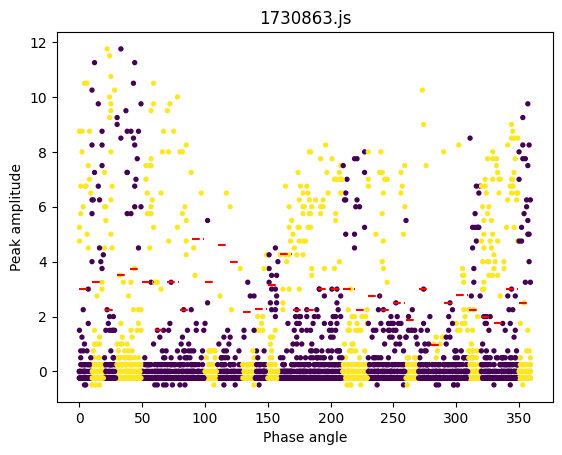

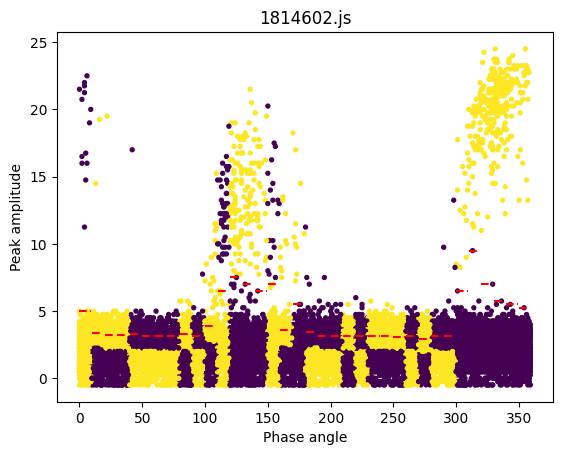

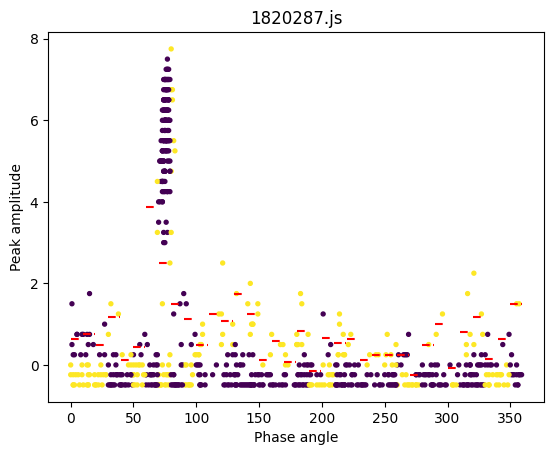

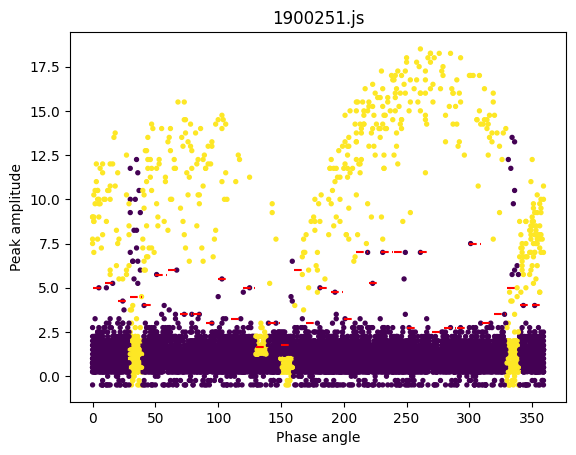

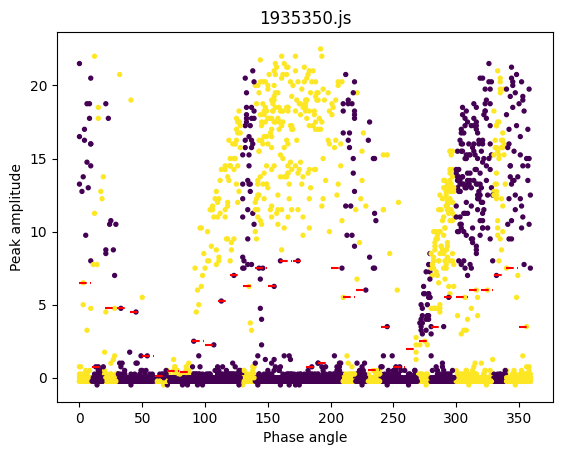

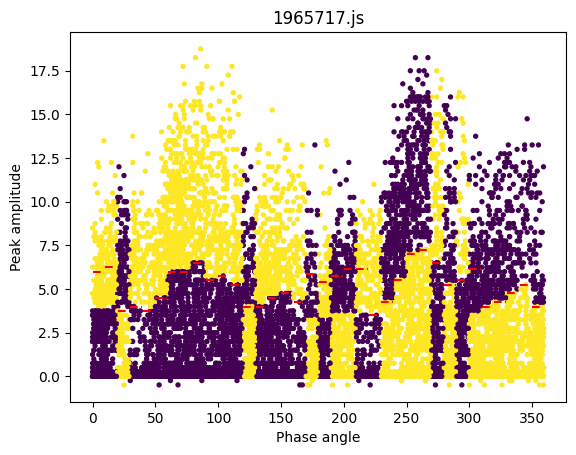

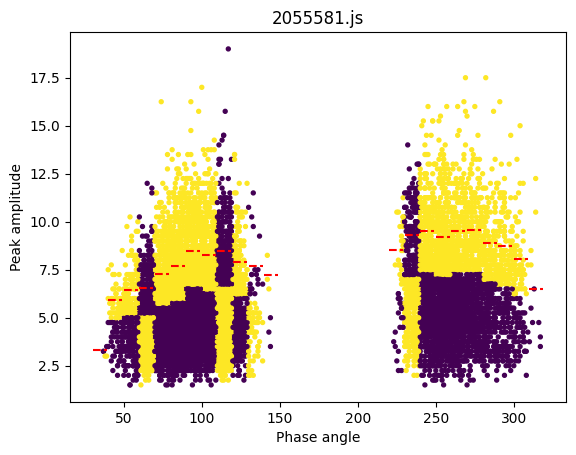

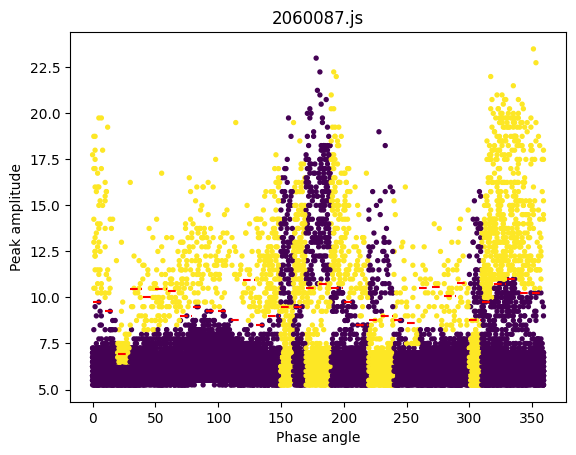

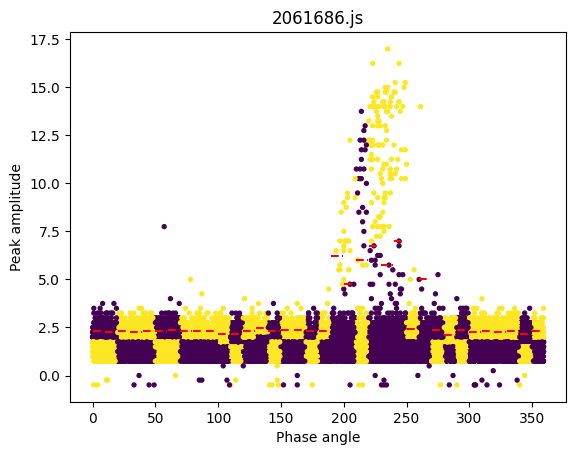

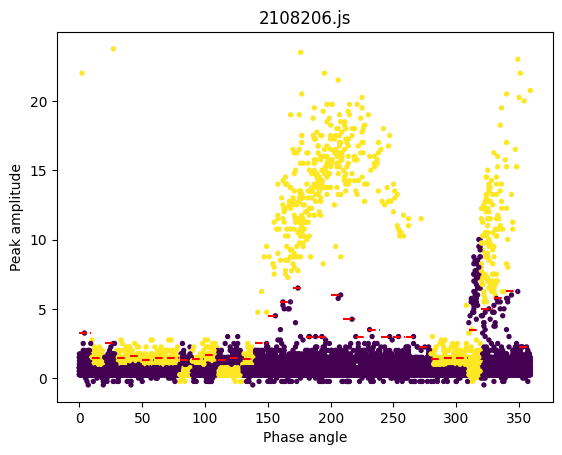

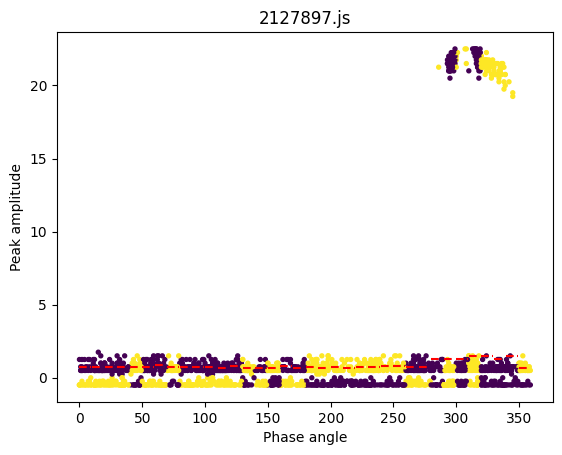

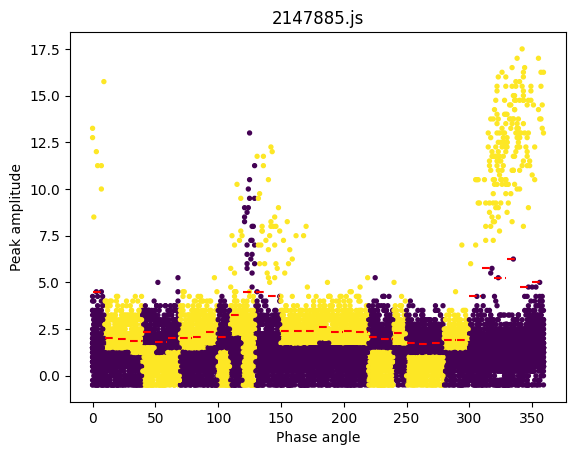

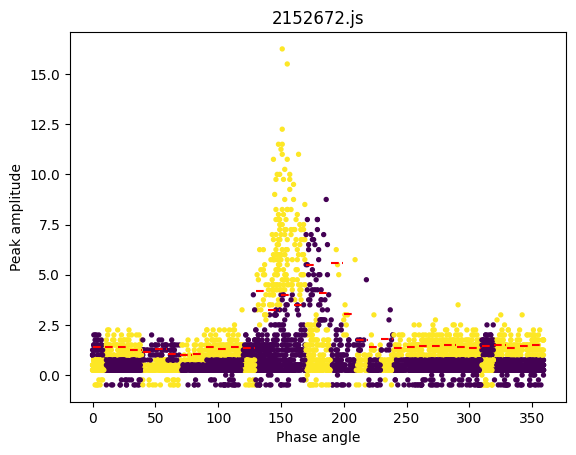

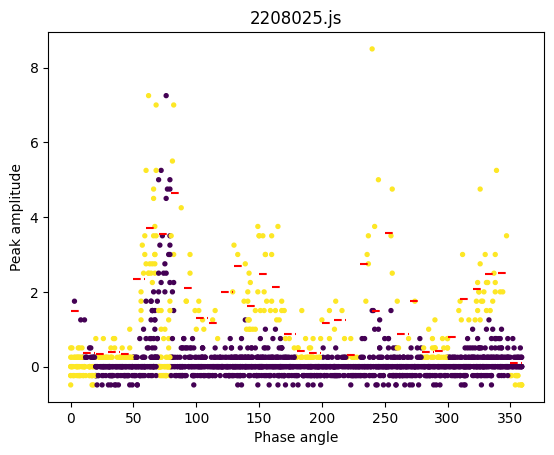

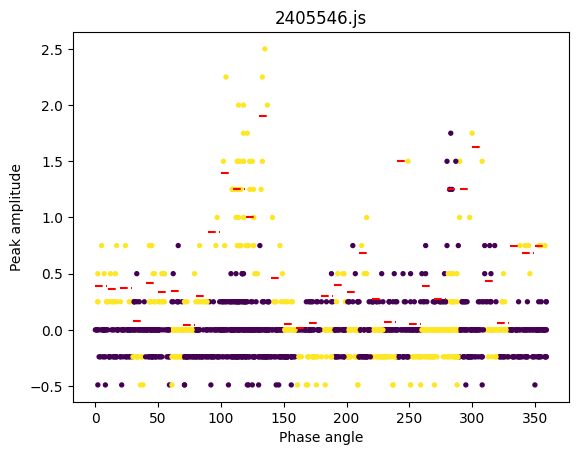

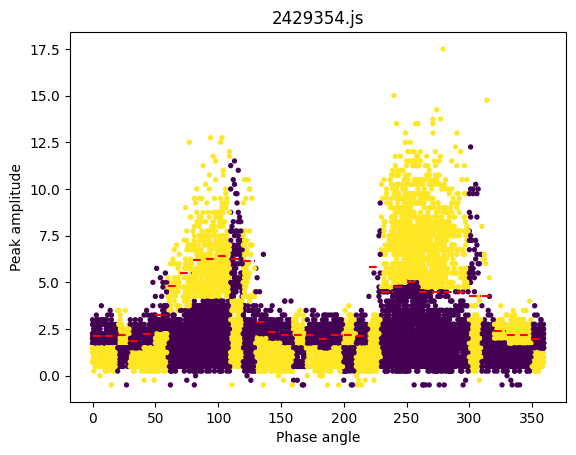

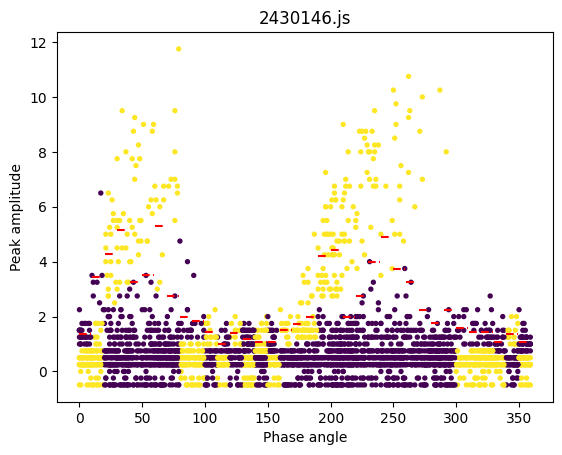

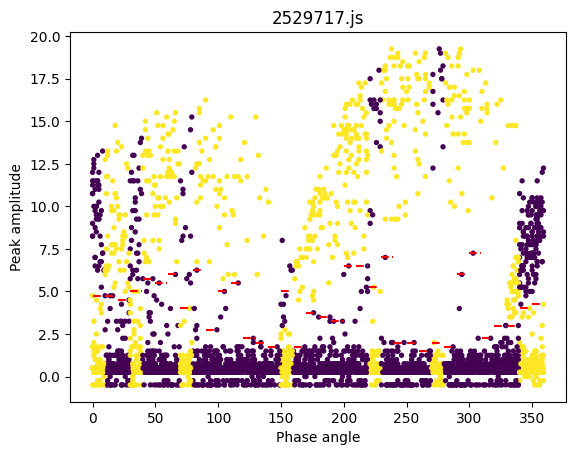

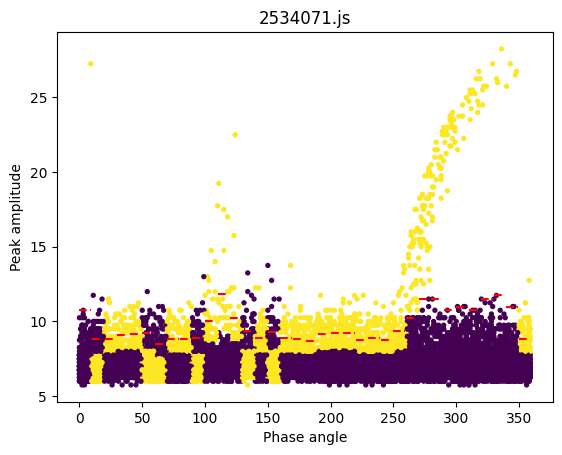

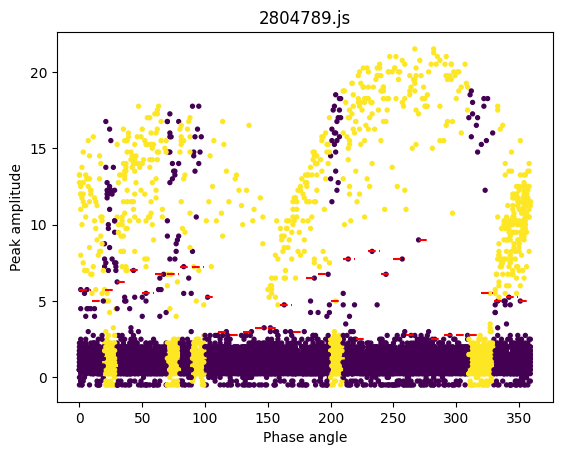

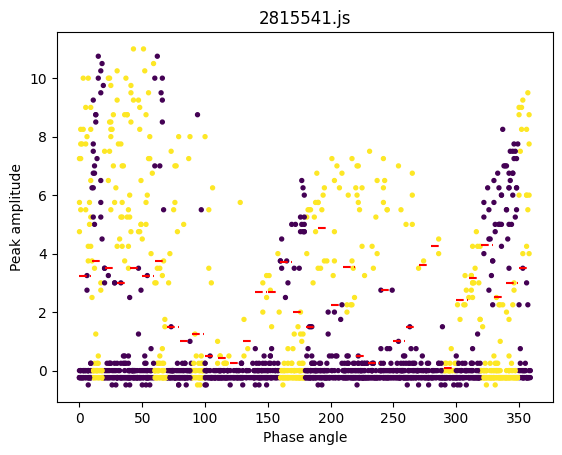

C:\Users\Dave\AppData\Local\Temp\ipykernel_23036\1019332274.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
C:\Users\Dave\AppData\Local\Temp\ipykernel_23036\1019332274.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
C:\Users\Dave\AppData\Local\Temp\ipykernel_23036\1019332274.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))


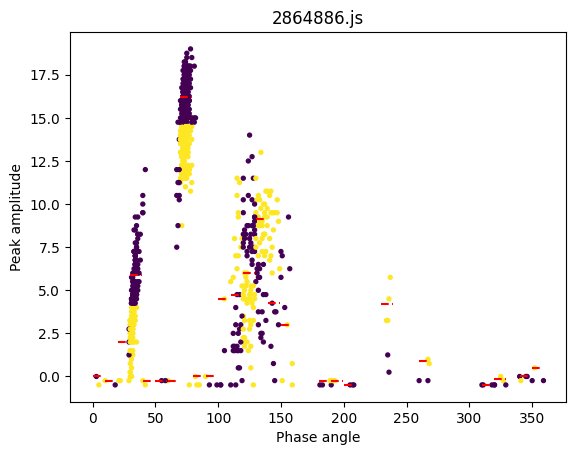

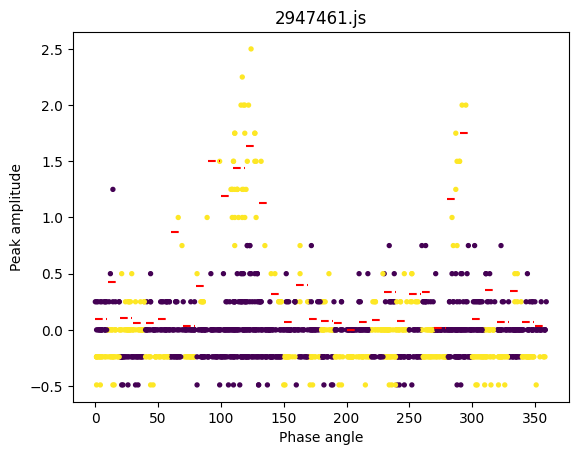

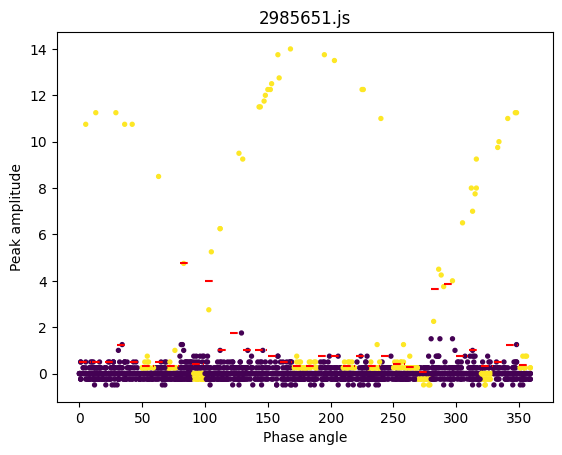

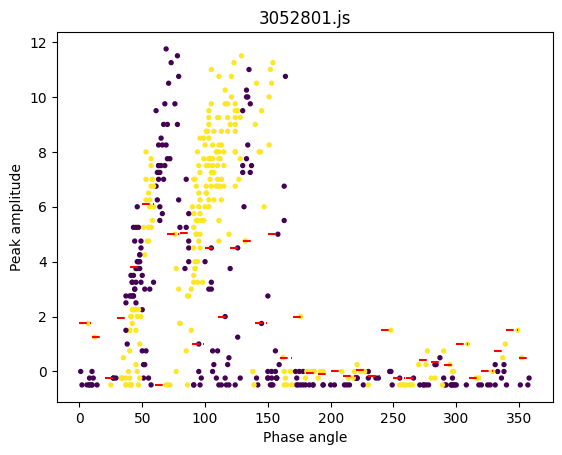

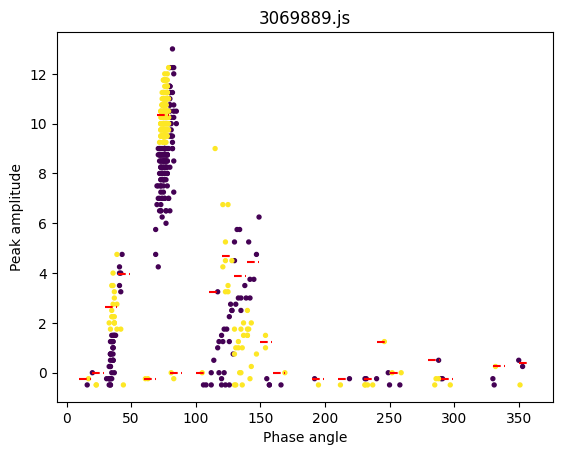

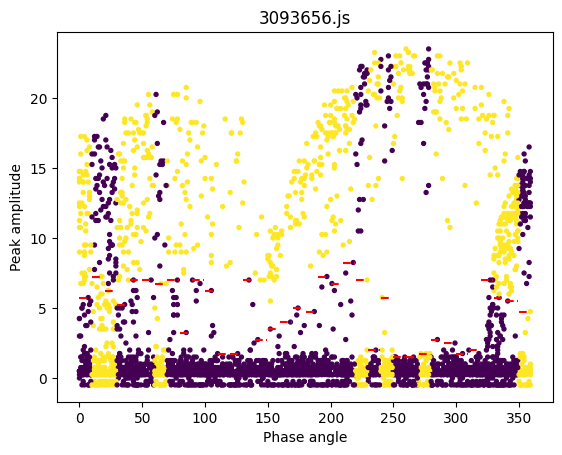

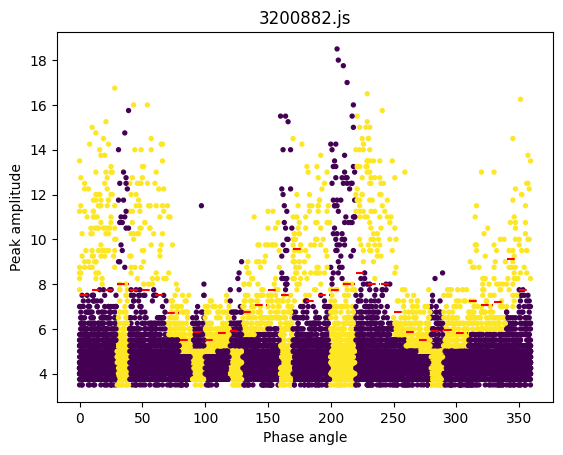

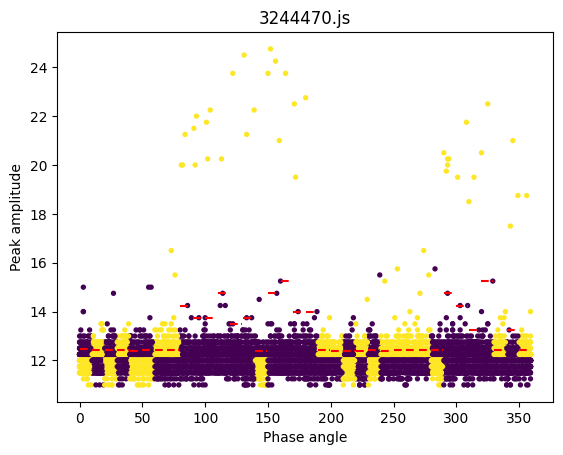

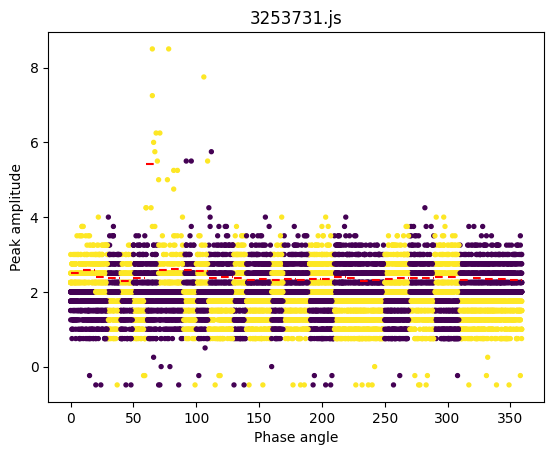

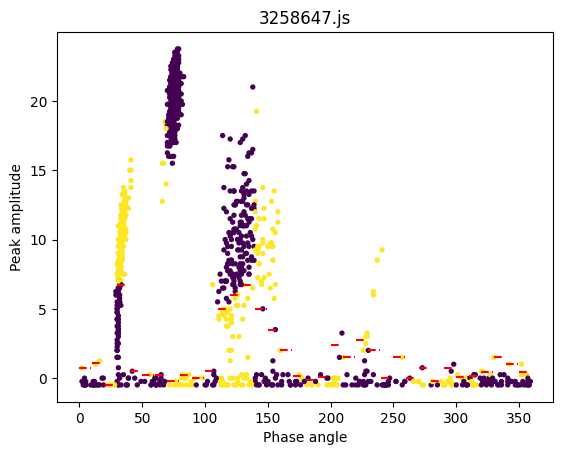

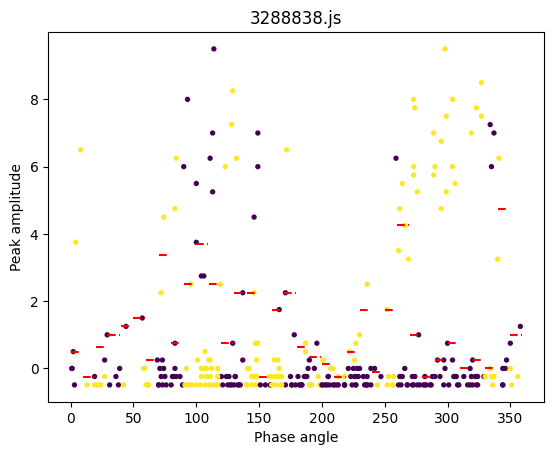

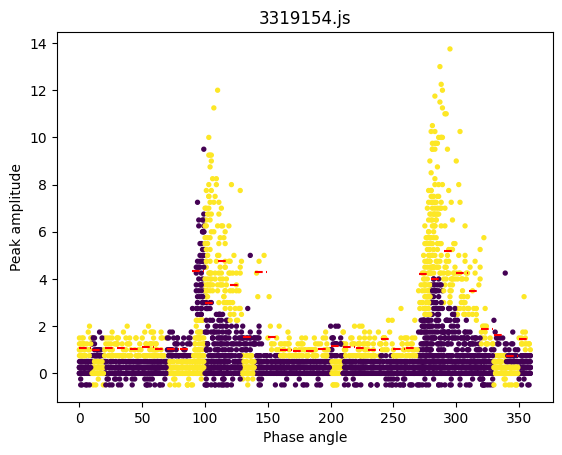

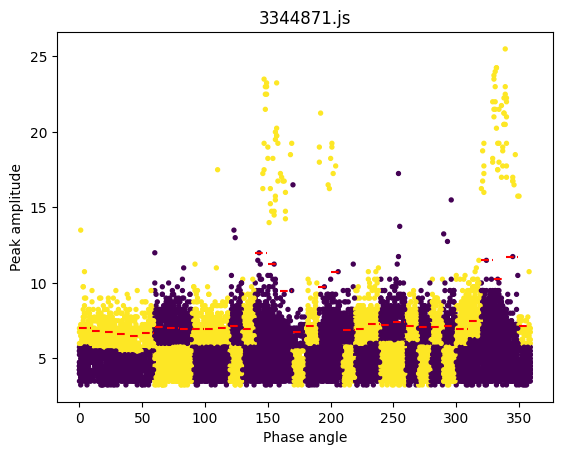

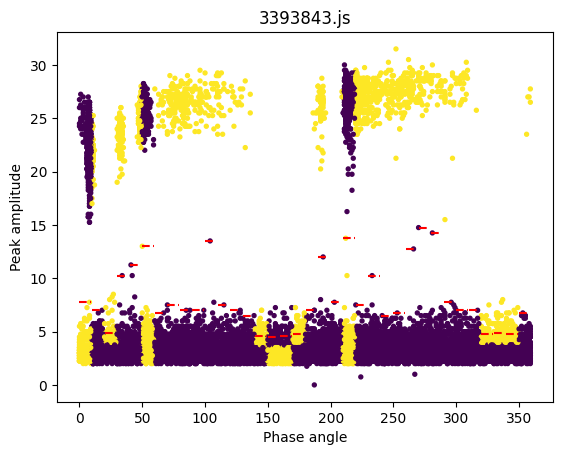

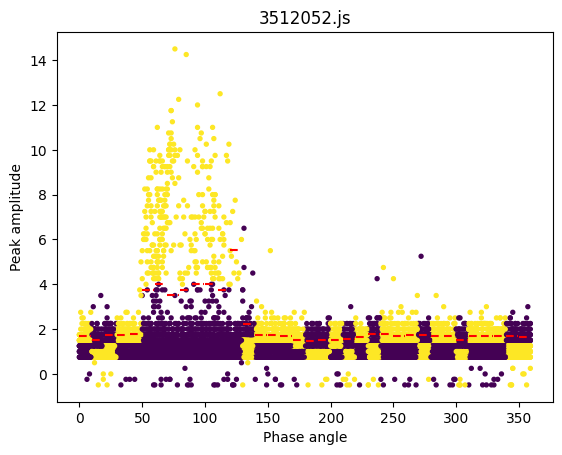

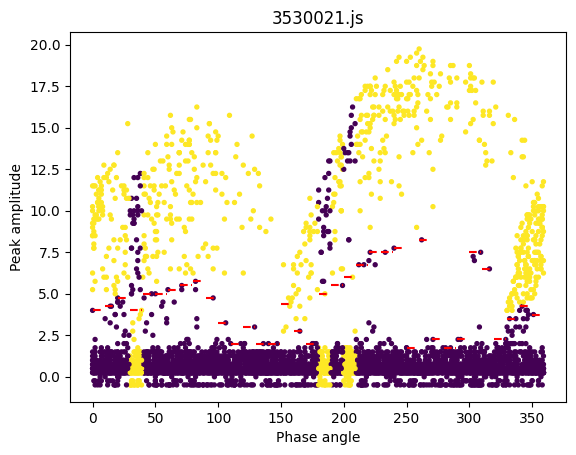

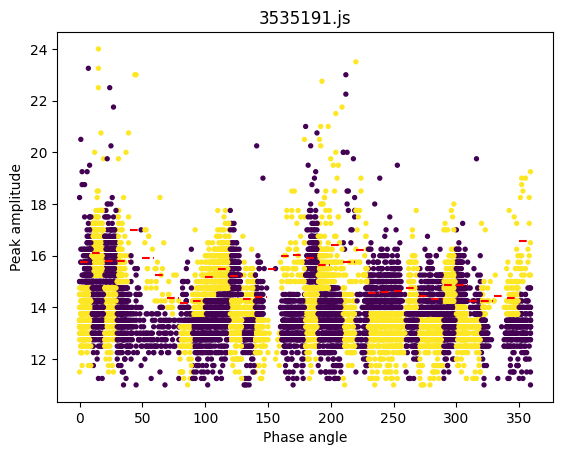

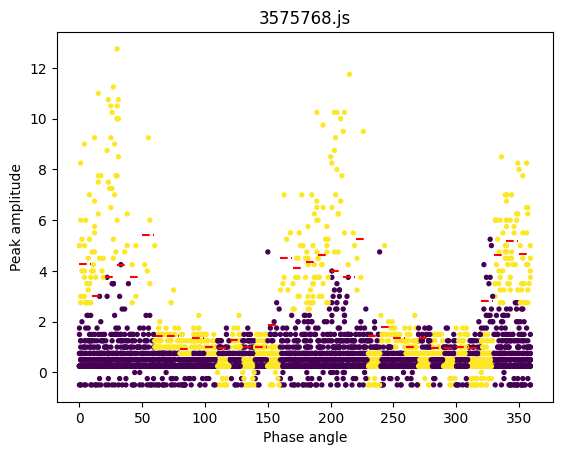

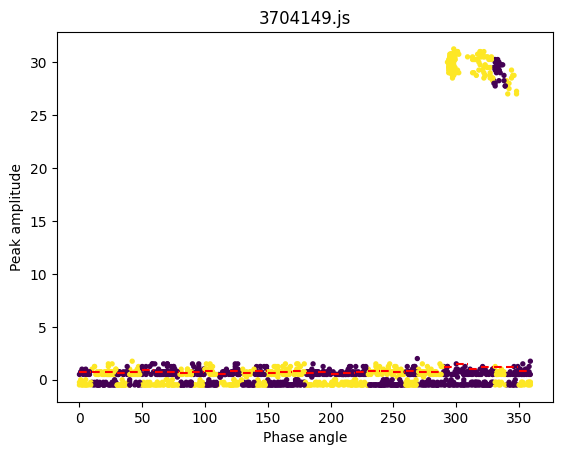

C:\Users\Dave\AppData\Local\Temp\ipykernel_23036\1019332274.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
C:\Users\Dave\AppData\Local\Temp\ipykernel_23036\1019332274.py:16: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))


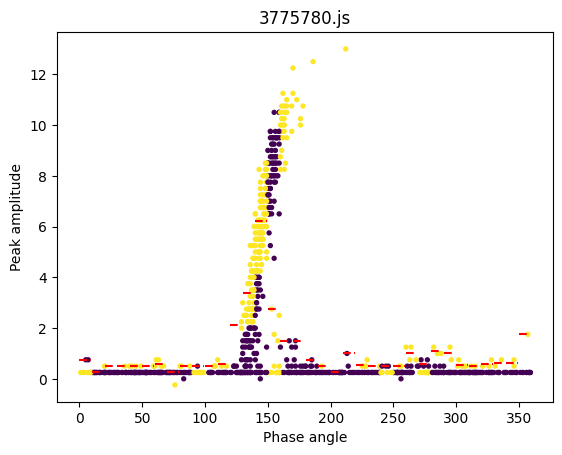

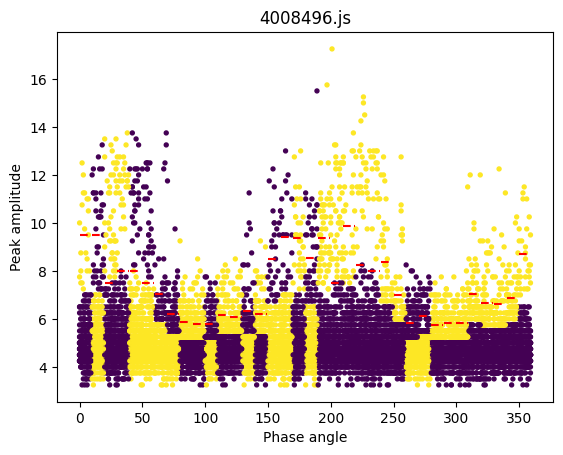

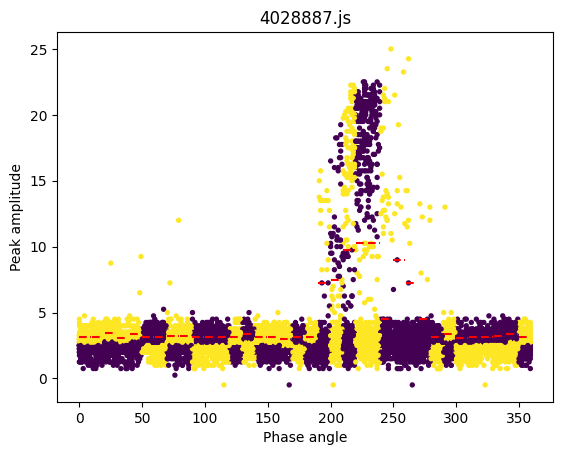

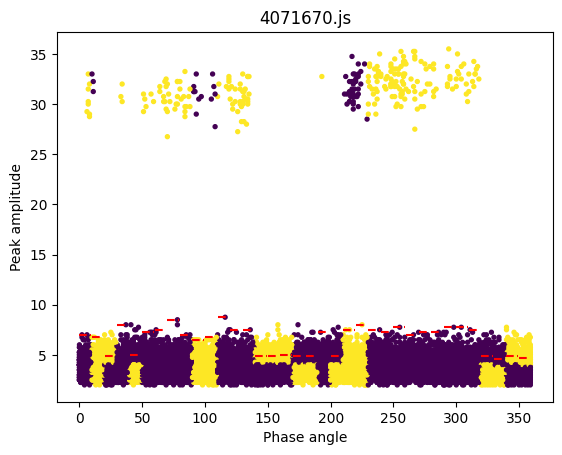

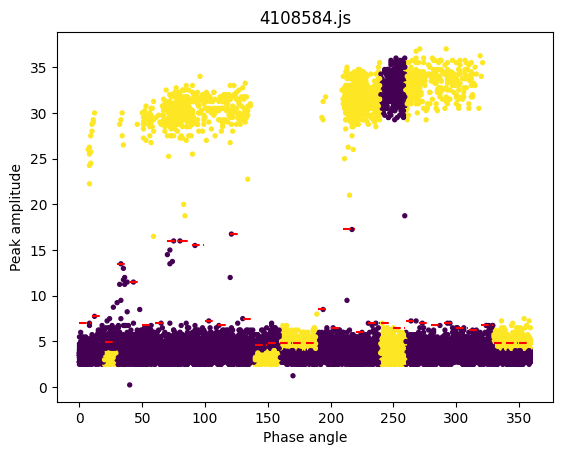

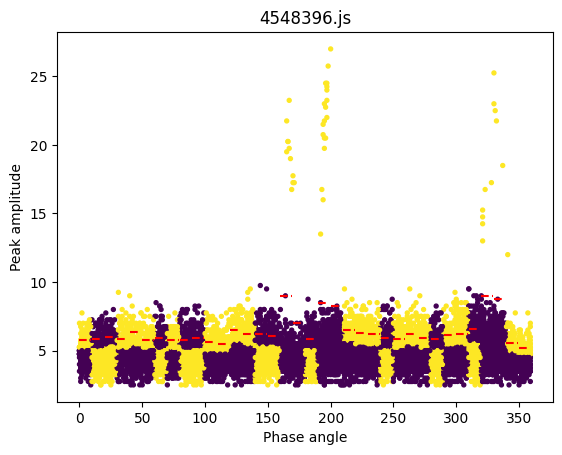

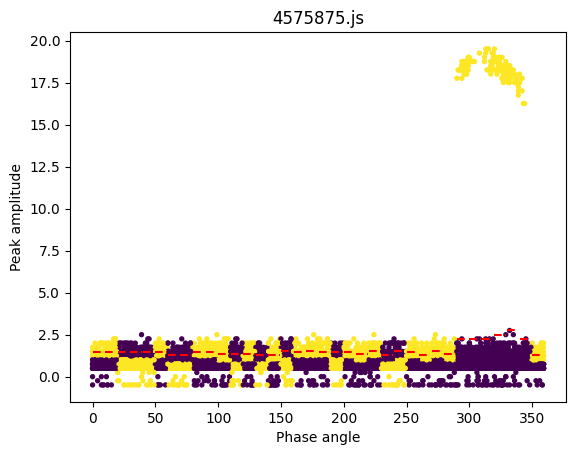

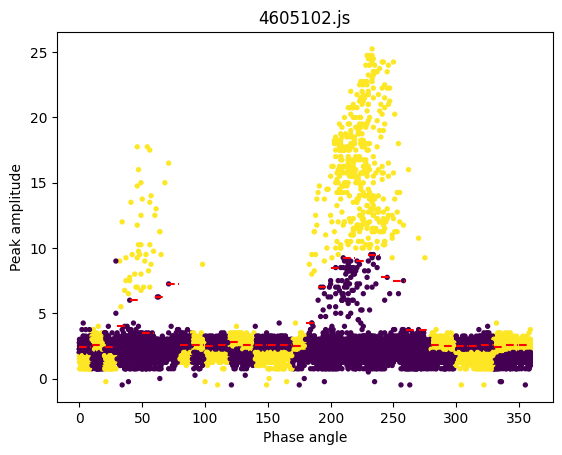

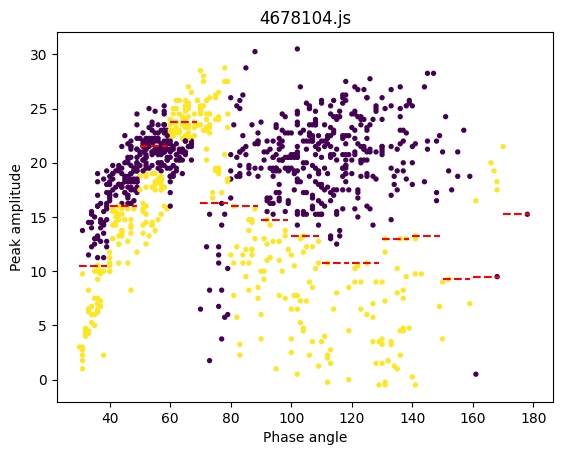

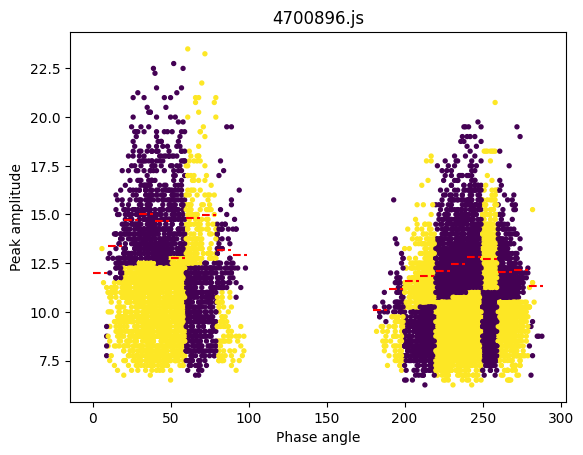

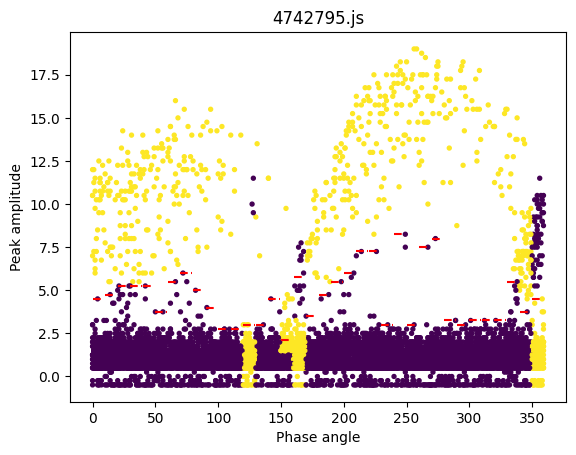

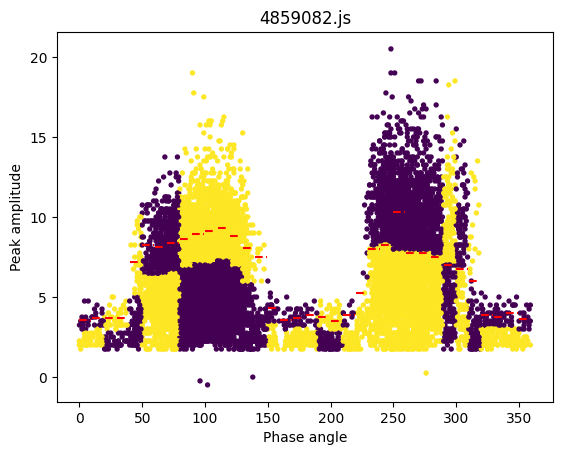

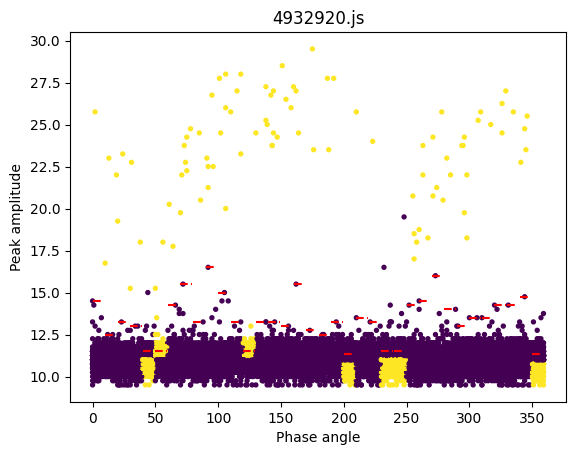

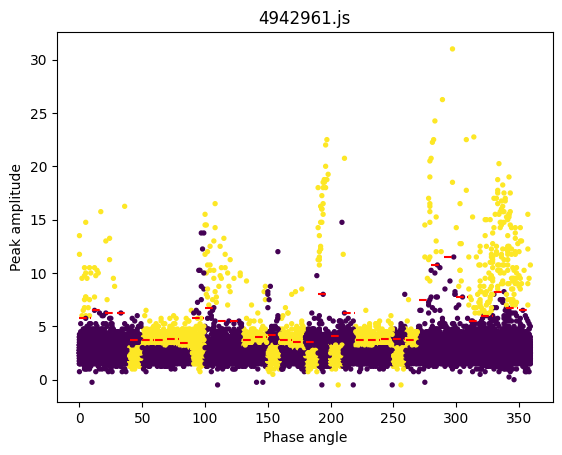

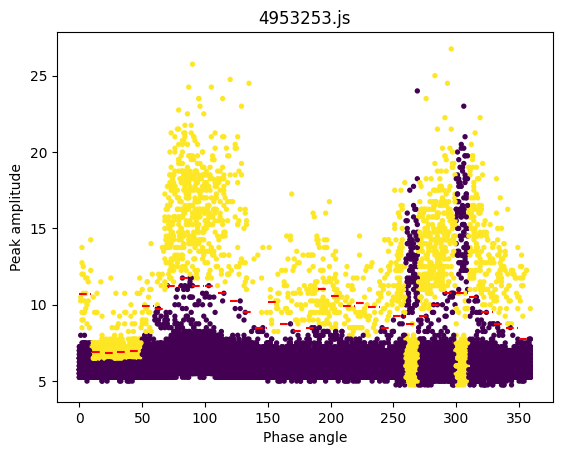

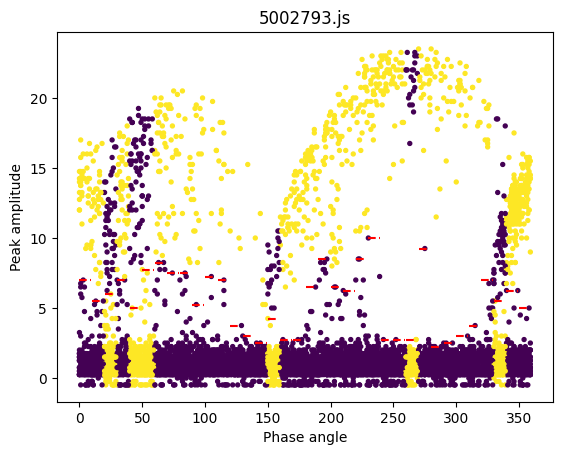

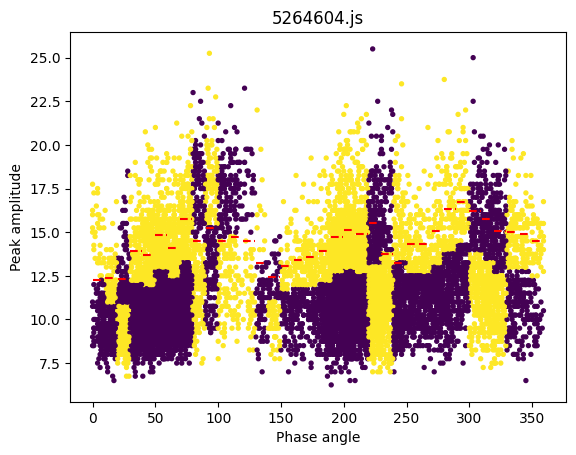

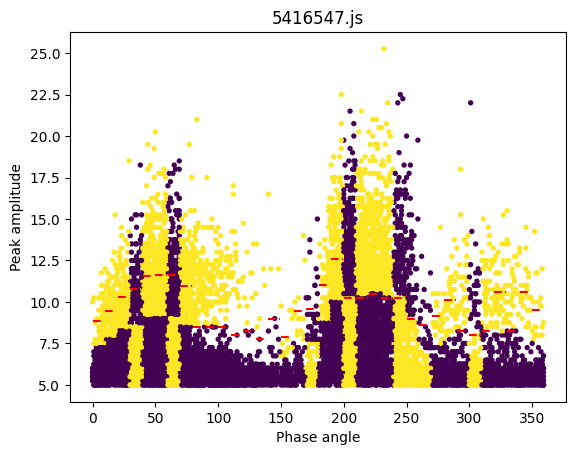

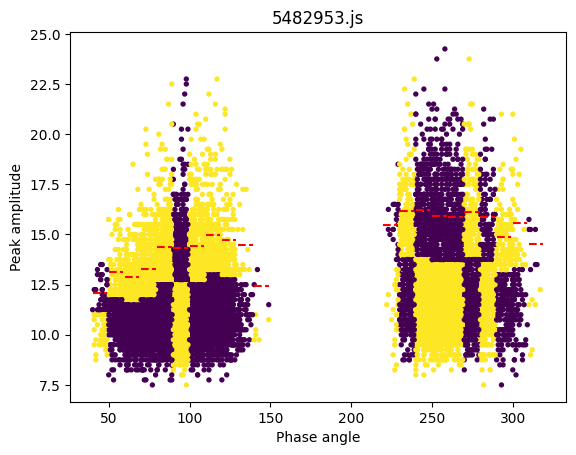

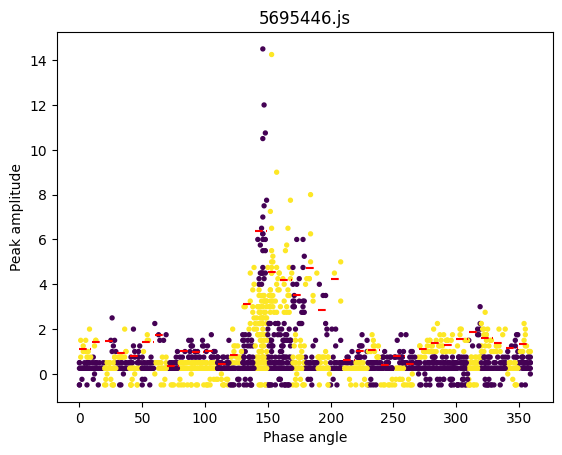

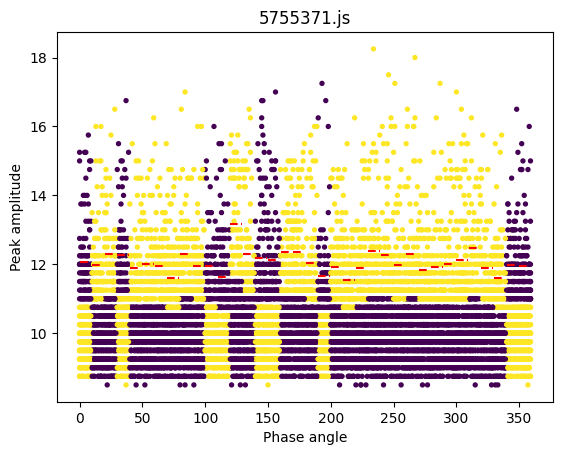

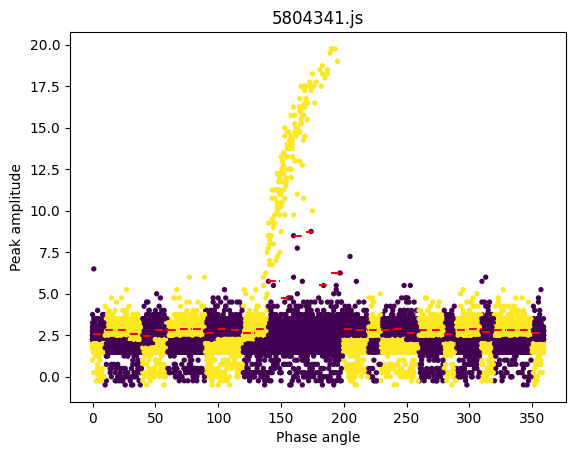

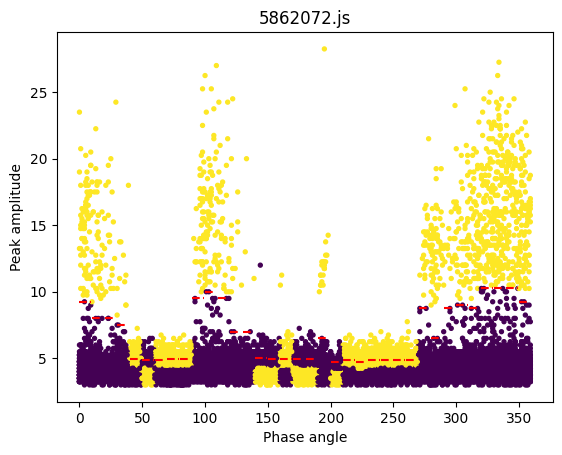

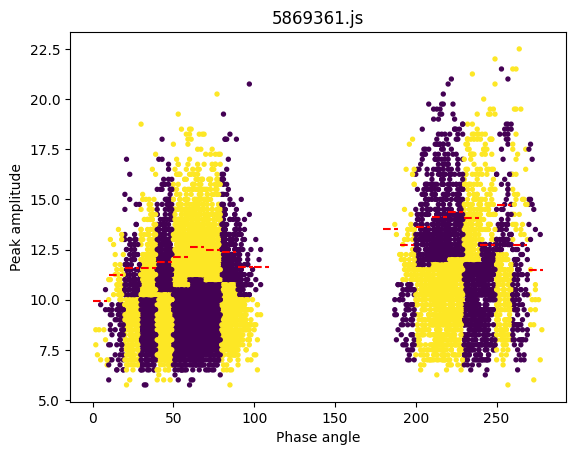

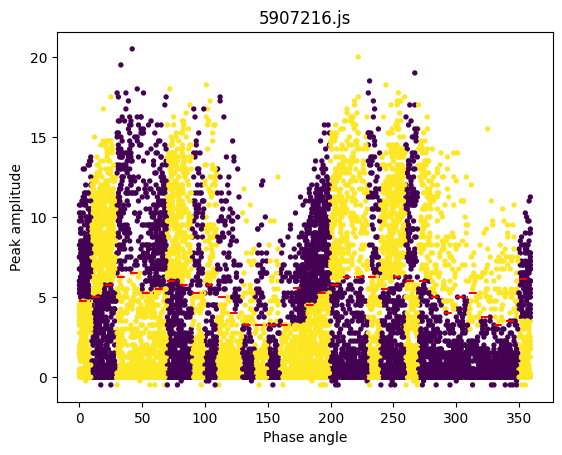

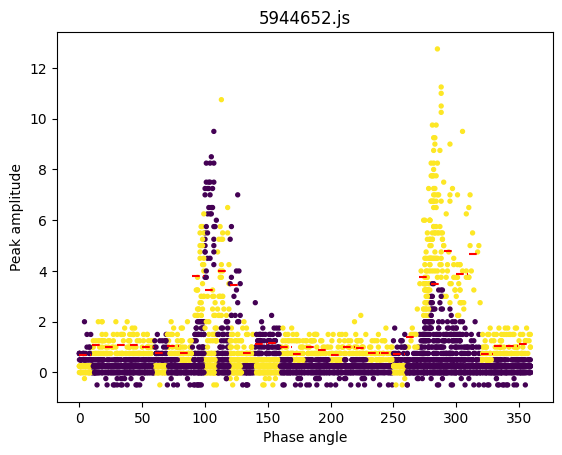

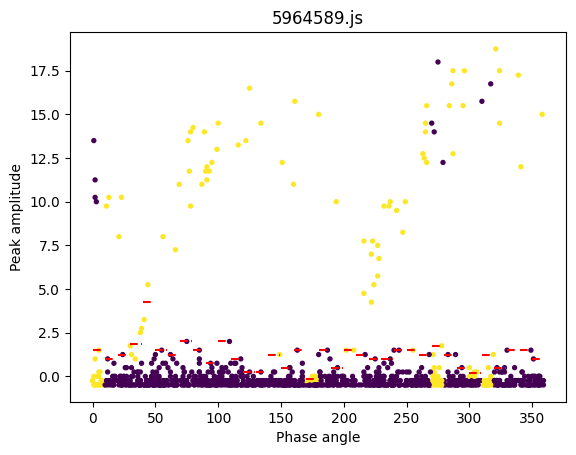

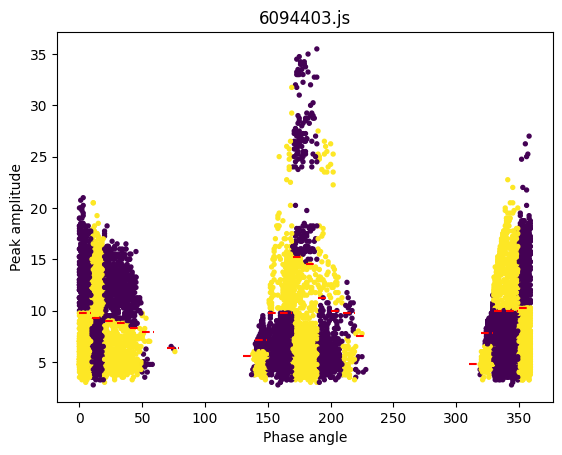

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [122]:
for filename in os.listdir(dirpath):
    if filename.endswith(".js"):
        filepath = os.path.join(dirpath, filename)
        waveform = load_waveform(filepath)
        if waveform is not None:
            # Bucket phase angles
            waveform['bucketed_phase_angle'] = waveform['phase_angle'].apply(bucket_phase_angle)

            # Inserted: Perform k-means clustering on each bucket and determine baselines
            kmeans_results = []
            bucket_baselines = []
            for i in range(36):
                bucket_data = waveform[waveform['bucketed_phase_angle'] == i]
                if not bucket_data.empty and len(bucket_data) > 1:
                    kmeans = KMeans(n_clusters=2, random_state=0)
                    kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
                    kmeans_results.append((i, kmeans))

                    # Predict the clusters for bucket_data
                    predicted_clusters = kmeans.predict(bucket_data['peak_amplitude'].values.reshape(-1, 1))

                    # Pass the predicted clusters to the determine_baseline function
                    baseline = determine_baseline(bucket_data, kmeans, predicted_clusters)
                    bucket_baselines.append((i, baseline))
                else:
                    kmeans_results.append((i, None))
                    bucket_baselines.append((i, None))

            # Assign cluster labels to each data point
            clustered_waveform = copy.deepcopy(waveform)
            for i, kmeans in kmeans_results:
                if kmeans is not None:
                    mask = clustered_waveform['bucketed_phase_angle'] == i
                    clustered_waveform.loc[mask, 'cluster'] = kmeans.predict(clustered_waveform.loc[mask, 'peak_amplitude'].values.reshape(-1, 1))

            # Scatter plot with bucketed phase angles and clustered data points
            plt.scatter(clustered_waveform['phase_angle'], clustered_waveform['peak_amplitude'], c=clustered_waveform['cluster'], cmap='viridis', s=8)
            plt.title(filename)
            plt.xlabel('Phase angle')
            plt.ylabel('Peak amplitude')

            # Plot baselines
            for i, baseline in bucket_baselines:
                if baseline is not None:
                    plt.hlines(baseline, i * 10, (i + 1) * 10 - 1, colors='r', linestyles='dashed')

            plt.show()

            # Save the plot
            output_filename = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_PRPD_plot.png")
            plt.savefig(output_filename, dpi=300)
            plt.close()

In [ ]:
# for filename in os.listdir(dirpath):
#     if filename.endswith(".js"):
#         filepath = os.path.join(dirpath, filename)
#         waveform = load_waveform(filepath)
#         if waveform is not None:
#             # Bucket phase angles
#             waveform['bucketed_phase_angle'] = waveform['phase_angle'].apply(bucket_phase_angle)
            
#             # Scatter plot with bucketed phase angles
#             plt.scatter(waveform['bucketed_phase_angle'], waveform['peak_amplitude'], s=8, cmap=cmx.plasma)
#             plt.title(filename)
#             plt.xlabel('Bucketed phase angle')
#             plt.ylabel('Peak amplitude')
#             plt.xticks(np.arange(0, 36, 1))
            
#             # Save the plot to the output folder
#             output_filepath = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")
#             plt.savefig(output_filepath)
            
#             # Clear the current plot to avoid overlapping
#             plt.clf()